This is a Jupyter notebook created for binary classification model generation.
- We will be loading the data in this notebook from SQL database.
- Perform EDA
- Perform NLP on the chat data that we have
- Feature Engineering
- Split data into training and testing datasets
- Perform model training on multiple models
- Select best performing model
- Final evaluation on the model

# Step 1 : Data Ingestion

In [27]:
# Importing the necessary modules
import pandas as pd
import numpy as np
import pyodbc

In [28]:
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 18 for SQL Server']


Had only Sql Server. 

So had to download Visual C++ Redistributable on the VM.

(https://www.microsoft.com/en-us/download/details.aspx?id=48145&msockid=0da8057f8f2a68053435137c8eed6912)

Also downloaded ODBC Driver 18 for SQL Server which had a prequisite of Visual C++ Redistributable on the VM.

(https://learn.microsoft.com/en-us/sql/connect/odbc/download-odbc-driver-for-sql-server?view=sql-server-ver17#download-for-windows)

In [37]:
# Database details are saved in .env file and can read as 
# part of environment variables.

from dotenv import load_dotenv
import os

In [38]:
# To load the .env file
load_dotenv()

True

In [39]:
SERVER = os.getenv("SERVER")    
DATABASE = os.getenv("DATABASE")   
USERNAME = os.getenv("DB_USERNAME")
PASSWORD = os.getenv("DB_PASSWORD")

In [40]:
print(SERVER)
print(DATABASE)
print(USERNAME)
print(PASSWORD)

sql-ss.database.windows.net
CutomerChurnDB
sqladmin
June@06062025


In [52]:
conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 18 for SQL Server}};'
    f'SERVER={SERVER};'
    f'DATABASE={DATABASE};'
    f'UID={USERNAME};'
    f'PWD={PASSWORD};'
    f'TrustServerCertificate=yes;'
    f'Encrypt=yes;'
    f'Connection Timeout=40;'
)

In [53]:
query = "SELECT * FROM dbo.User_Churn"

df_orginal = pd.read_sql(query, conn)

# Close connection (optional)
conn.close()

C:\Users\Admin-Syntax-Squad\AppData\Local\Temp\ipykernel_4528\786611006.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orginal = pd.read_sql(query, conn)


In [54]:
df_orginal.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,chat_text
0,KS,128,415,False,True,25,265.100006,110,45.070000,197.399994,...,16.780001,244.699997,91,11.01,10.0,3,2.70,1,False,I've called three times and still no solution.
1,OH,107,415,False,True,26,161.600006,123,27.469999,195.500000,...,16.620001,254.399994,103,11.45,13.7,3,3.70,1,False,Why is my bill so high again?
2,NJ,137,415,False,False,0,243.399994,114,41.380001,121.199997,...,10.300000,162.600006,104,7.32,12.2,5,3.29,0,False,I'm very unhappy with your service.
3,OH,84,408,True,False,0,299.399994,71,50.900002,61.900002,...,5.260000,196.899994,89,8.86,6.6,7,1.78,2,False,This is the worst service ever.
4,OK,75,415,True,False,0,166.699997,113,28.340000,148.300003,...,12.610000,186.899994,121,8.41,10.1,3,2.73,3,False,Why is my bill so high again?


# Step 2 : EDA

In [55]:
df_orginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account_length          2666 non-null   int64  
 2   Area_code               2666 non-null   int64  
 3   International_plan      2666 non-null   bool   
 4   Voice_mail_plan         2666 non-null   bool   
 5   Number_vmail_messages   2666 non-null   int64  
 6   Total_day_minutes       2666 non-null   float64
 7   Total_day_calls         2666 non-null   int64  
 8   Total_day_charge        2666 non-null   float64
 9   Total_eve_minutes       2666 non-null   float64
 10  Total_eve_calls         2666 non-null   int64  
 11  Total_eve_charge        2666 non-null   float64
 12  Total_night_minutes     2666 non-null   float64
 13  Total_night_calls       2666 non-null   int64  
 14  Total_night_charge      2666 non-null   

In [56]:
df_orginal["Churn"] = df_orginal["Churn"].astype("int")
df_orginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account_length          2666 non-null   int64  
 2   Area_code               2666 non-null   int64  
 3   International_plan      2666 non-null   bool   
 4   Voice_mail_plan         2666 non-null   bool   
 5   Number_vmail_messages   2666 non-null   int64  
 6   Total_day_minutes       2666 non-null   float64
 7   Total_day_calls         2666 non-null   int64  
 8   Total_day_charge        2666 non-null   float64
 9   Total_eve_minutes       2666 non-null   float64
 10  Total_eve_calls         2666 non-null   int64  
 11  Total_eve_charge        2666 non-null   float64
 12  Total_night_minutes     2666 non-null   float64
 13  Total_night_calls       2666 non-null   int64  
 14  Total_night_charge      2666 non-null   

In [57]:
df_orginal.describe()

,Account_length,Area_code,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.481620,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641,0.145536
std,39.563974,42.521018,13.612277,54.210350,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236,0.352707
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700001,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.399994,87.000000,24.379999,165.300003,87.000000,14.050000,166.924995,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000,0.000000
50%,100.000000,415.000000,0.000000,179.949997,101.000000,30.590000,200.899994,100.000000,17.080000,201.150002,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000,0.000000
75%,127.000000,510.000000,19.000000,215.899994,114.000000,36.700001,235.100006,114.000000,19.980000,236.474998,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,50.000000,350.799988,160.000000,59.639999,363.700012,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [58]:
df_orginal.isna().sum()

State                     0
Account_length            0
Area_code                 0
International_plan        0
Voice_mail_plan           0
Number_vmail_messages     0
Total_day_minutes         0
Total_day_calls           0
Total_day_charge          0
Total_eve_minutes         0
Total_eve_calls           0
Total_eve_charge          0
Total_night_minutes       0
Total_night_calls         0
Total_night_charge        0
Total_intl_minutes        0
Total_intl_calls          0
Total_intl_charge         0
Customer_service_calls    0
Churn                     0
chat_text                 0
dtype: int64

In [59]:
df_orginal.duplicated().sum()

np.int64(0)

Outcome of the EDA performed above:-
- Datatypes of the features are correctly mapped.
- Nmes of the features are have correct format.
- There is no null or NaN value in any of the features.
- There are no duplicated values in any of the features.

# Step 3 : Perform NLP on "chat_text" feature and Feature Engineering

Creating some additional features based on chat_text

In [60]:
df_copy = df_orginal.copy()

In [61]:
df_copy["chat_text_length"] = df_copy["chat_text"].str.len()
df_copy.head(3)

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,chat_text,chat_text_length
0,KS,128,415,False,True,25,265.100006,110,45.070000,197.399994,...,244.699997,91,11.01,10.0,3,2.70,1,0,I've called three times and still no solution.,46
1,OH,107,415,False,True,26,161.600006,123,27.469999,195.500000,...,254.399994,103,11.45,13.7,3,3.70,1,0,Why is my bill so high again?,29
2,NJ,137,415,False,False,0,243.399994,114,41.380001,121.199997,...,162.600006,104,7.32,12.2,5,3.29,0,0,I'm very unhappy with your service.,35


Calculating average length of chat_text_length feature for user those got churned and those retained

In [63]:
df_copy["chat_text_length"].groupby(df_copy["Churn"]).mean()

Churn
0    36.157594
1    35.046392
Name: chat_text_length, dtype: float64

In [65]:
# Visualising the distribution of chat_text_length
# Create two histograms in one plot
import matplotlib.pyplot as plt
import seaborn as sns

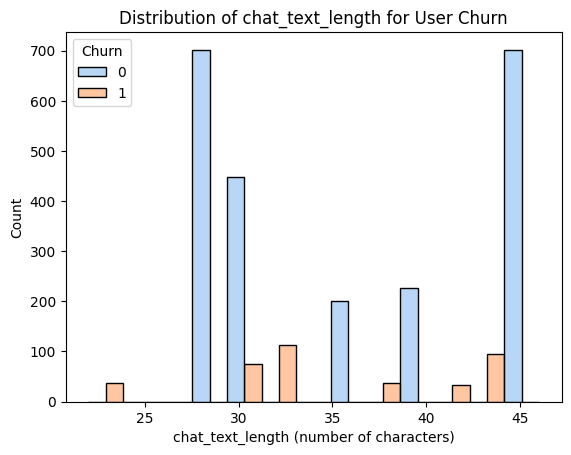

In [66]:
sns.histplot(data=df_copy, stat="count", multiple="dodge", x="chat_text_length",
             kde=False, palette="pastel", hue="Churn",
             element="bars", legend=True)
plt.xlabel("chat_text_length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of chat_text_length for User Churn")
plt.show()

In [67]:
df_copy['chat_text_word_count'] = df_copy['chat_text'].apply(lambda x: len(x.split()))
df_copy.head(3)

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,chat_text,chat_text_length,chat_text_word_count
0,KS,128,415,False,True,25,265.100006,110,45.070000,197.399994,...,91,11.01,10.0,3,2.70,1,0,I've called three times and still no solution.,46,8
1,OH,107,415,False,True,26,161.600006,123,27.469999,195.500000,...,103,11.45,13.7,3,3.70,1,0,Why is my bill so high again?,29,7
2,NJ,137,415,False,False,0,243.399994,114,41.380001,121.199997,...,104,7.32,12.2,5,3.29,0,0,I'm very unhappy with your service.,35,6


In [68]:
df_copy["chat_text_word_count"].groupby(df_copy["Churn"]).mean()

Churn
0    6.517559
1    5.734536
Name: chat_text_word_count, dtype: float64

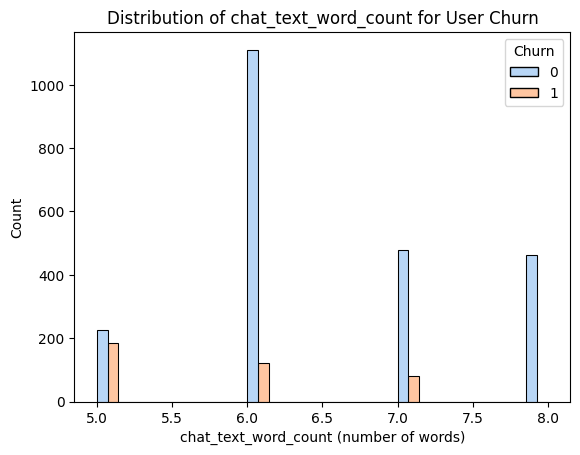

In [69]:
sns.histplot(data=df_copy, stat="count", multiple="dodge", x="chat_text_word_count",
             kde=False, palette="pastel", hue="Churn",
             element="bars", legend=True)
plt.xlabel("chat_text_word_count (number of words)")
plt.ylabel("Count")
plt.title("Distribution of chat_text_word_count for User Churn")
plt.show()

How Sentiment Scoring Works with TextBlob
Each chat message in your chat_text column is passed through TextBlob, which gives you two values:

- polarity: A number between -1 (very negative) and 1 (very positive)

- subjectivity: A number between 0 (very objective) and 1 (very subjective)

In [71]:
from textblob import TextBlob

In [72]:
df_copy['sentiment_polarity'] = df_copy['chat_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_copy['sentiment_subjectivity'] = df_copy['chat_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

df_copy.head(3)

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,chat_text,chat_text_length,chat_text_word_count,sentiment_polarity,sentiment_subjectivity
0,KS,128,415,False,True,25,265.100006,110,45.070000,197.399994,...,10.0,3,2.70,1,0,I've called three times and still no solution.,46,8,0.00,0.00
1,OH,107,415,False,True,26,161.600006,123,27.469999,195.500000,...,13.7,3,3.70,1,0,Why is my bill so high again?,29,7,0.16,0.54
2,NJ,137,415,False,False,0,243.399994,114,41.380001,121.199997,...,12.2,5,3.29,0,0,I'm very unhappy with your service.,35,6,-0.78,1.00


In [73]:
# Classify as Positive/Negative/Neutral
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

In [74]:
df_copy['sentiment_label'] = df_copy['sentiment_polarity'].apply(classify_sentiment)

In [75]:
df_copy.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,chat_text,chat_text_length,chat_text_word_count,sentiment_polarity,sentiment_subjectivity,sentiment_label
0,KS,128,415,False,True,25,265.100006,110,45.070000,197.399994,...,3,2.70,1,0,I've called three times and still no solution.,46,8,0.00,0.00,Neutral
1,OH,107,415,False,True,26,161.600006,123,27.469999,195.500000,...,3,3.70,1,0,Why is my bill so high again?,29,7,0.16,0.54,Positive
2,NJ,137,415,False,False,0,243.399994,114,41.380001,121.199997,...,5,3.29,0,0,I'm very unhappy with your service.,35,6,-0.78,1.00,Negative
3,OH,84,408,True,False,0,299.399994,71,50.900002,61.900002,...,7,1.78,2,0,This is the worst service ever.,31,6,-1.00,1.00,Negative
4,OK,75,415,True,False,0,166.699997,113,28.340000,148.300003,...,3,2.73,3,0,Why is my bill so high again?,29,7,0.16,0.54,Positive


In [101]:
df_final = df_copy.copy()

In [102]:
df_final = pd.concat([df_final, pd.get_dummies(df_final["sentiment_label"], prefix="sentiment", drop_first=False).astype(int)], axis=1)
df_final.head(3)


,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Churn,chat_text,chat_text_length,chat_text_word_count,sentiment_polarity,sentiment_subjectivity,sentiment_label,sentiment_Negative,sentiment_Neutral,sentiment_Positive
0,KS,128,415,False,True,25,265.100006,110,45.070000,197.399994,...,0,I've called three times and still no solution.,46,8,0.00,0.00,Neutral,0,1,0
1,OH,107,415,False,True,26,161.600006,123,27.469999,195.500000,...,0,Why is my bill so high again?,29,7,0.16,0.54,Positive,0,0,1
2,NJ,137,415,False,False,0,243.399994,114,41.380001,121.199997,...,0,I'm very unhappy with your service.,35,6,-0.78,1.00,Negative,1,0,0


In [103]:
df_final["International_plan"] = df_final["International_plan"].astype("int")
df_final["Voice_mail_plan"] = df_final["Voice_mail_plan"].astype("int")
df_final.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,...,Churn,chat_text,chat_text_length,chat_text_word_count,sentiment_polarity,sentiment_subjectivity,sentiment_label,sentiment_Negative,sentiment_Neutral,sentiment_Positive
0,KS,128,415,0,1,25,265.100006,110,45.070000,197.399994,...,0,I've called three times and still no solution.,46,8,0.00,0.00,Neutral,0,1,0
1,OH,107,415,0,1,26,161.600006,123,27.469999,195.500000,...,0,Why is my bill so high again?,29,7,0.16,0.54,Positive,0,0,1
2,NJ,137,415,0,0,0,243.399994,114,41.380001,121.199997,...,0,I'm very unhappy with your service.,35,6,-0.78,1.00,Negative,1,0,0
3,OH,84,408,1,0,0,299.399994,71,50.900002,61.900002,...,0,This is the worst service ever.,31,6,-1.00,1.00,Negative,1,0,0
4,OK,75,415,1,0,0,166.699997,113,28.340000,148.300003,...,0,Why is my bill so high again?,29,7,0.16,0.54,Positive,0,0,1


In [104]:
df_final.drop(columns=["chat_text" , "sentiment_label" , "State", "sentiment_polarity"] , inplace=True)
df_final.head()

,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,...,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,chat_text_length,chat_text_word_count,sentiment_subjectivity,sentiment_Negative,sentiment_Neutral,sentiment_Positive
0,128,415,0,1,25,265.100006,110,45.070000,197.399994,99,...,3,2.70,1,0,46,8,0.00,0,1,0
1,107,415,0,1,26,161.600006,123,27.469999,195.500000,103,...,3,3.70,1,0,29,7,0.54,0,0,1
2,137,415,0,0,0,243.399994,114,41.380001,121.199997,110,...,5,3.29,0,0,35,6,1.00,1,0,0
3,84,408,1,0,0,299.399994,71,50.900002,61.900002,88,...,7,1.78,2,0,31,6,1.00,1,0,0
4,75,415,1,0,0,166.699997,113,28.340000,148.300003,122,...,3,2.73,3,0,29,7,0.54,0,0,1


# Step :4 Split the data into training set  , test set and validation set

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [105]:
X = df_final.drop(columns=["Churn"])
y = df_final["Churn"]

print(f"Shape of X : {X.shape}")
print(f"Shape of y : {y.shape}")

Shape of X : (2666, 24)
Shape of y : (2666,)


In [106]:
from sklearn.model_selection import train_test_split


In [107]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [108]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [109]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1599, 24), (533, 24), (534, 24), (1599,), (533,), (534,))

# Step : 5 Perform model training on multiple models

- RandomForrestClassifer
- XGBoost

In [110]:
# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

Building Random Forest Classifer

In [111]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Fit the RandomForrestClassifier

In [112]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 2min 1s
Wall time: 2min 8s


,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [5, 7, ...], 'max_features': [0.3, 0.6], 'max_samples': [0.7], 'min_samples_leaf': [1, 2], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,75


In [113]:
# Examine best recall score
rf_cv.best_score_

np.float64(1.0)

In [114]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [115]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val)

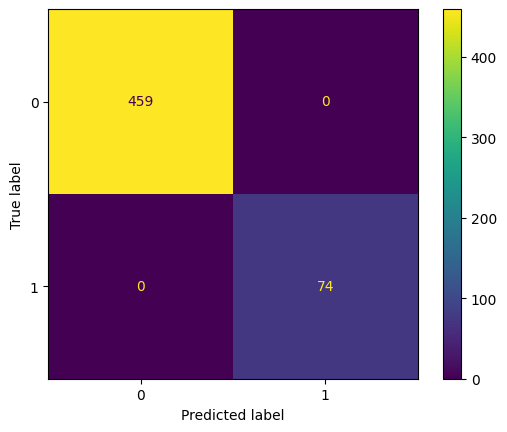

In [116]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

Building XGBoost model

In [117]:
from xgboost import XGBClassifier

In [118]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

Fit XGBClassifier

In [120]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 40.1 s
Wall time: 23.6 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, ...], 'min_child_weight': [3, 5], 'n_estimators': [300, 500]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [121]:
xgb_cv.best_score_

np.float64(1.0)

In [122]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

In [123]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val)

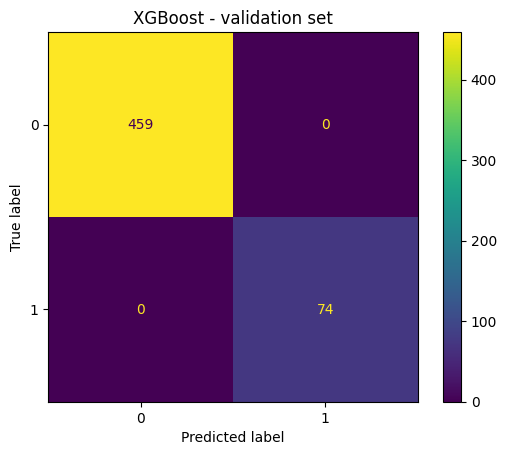

In [124]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()

## Response

Both RandomForestClassifer and XGBoostClassifer seem to be giving perfect classification. Since we have less data we are gettign the perfect classification. We will choose XGBoostClassifier as it seems to be taking less time to train as compared to RandomForestClassifier.

# Step : 6 Using Champion Model to predict on Test Dataset

In [125]:
# Use champion model to predict on test data
y_pred = xgb_cv.best_estimator_.predict(X_test)

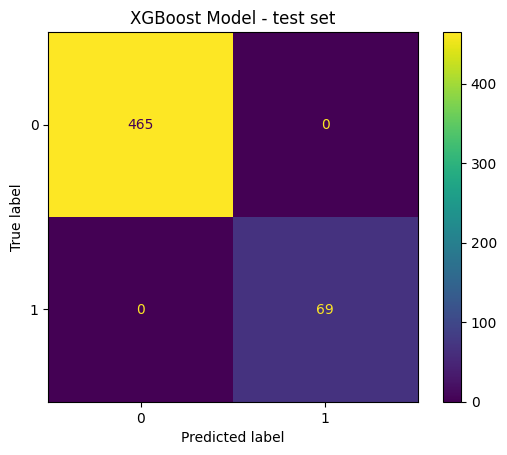

In [126]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost Model - test set');
plt.show()

## Feature Importances of the Champion Model

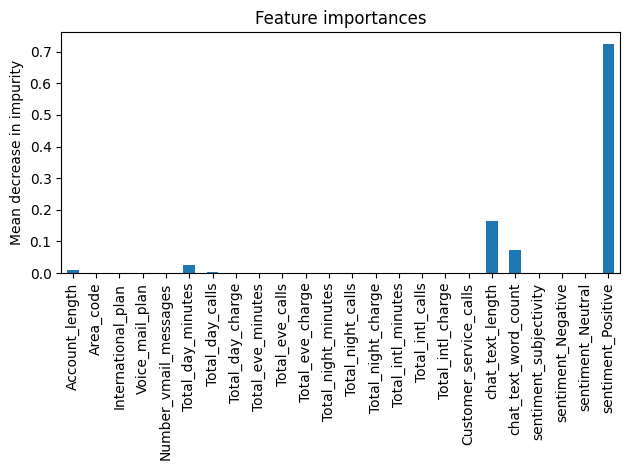

In [127]:
importances = xgb_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

# Response :

Engineered Feature sentiment_positive from sentiment polarity seems to be having the most influence on the model classification

# Step : 7 Save the champion model in pickle format

In [129]:
import pickle

In [ ]:
cd..

In [130]:
# Define the folder and filename
folder_path = os.path.join(os.getcwd(), "Saved_Models")
file_path = os.path.join(folder_path, "xgb_Telecom_User_Churn.pkl")

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Save the model
with open(file_path, 'wb') as f:
    pickle.dump(xgb_cv, f)